### xgboost model to predict mean player outcomes
used in conjunction with nn algs to determine mean wrc for player. Three diffrent models based on available data then combinded to create an xgb predection.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
function_dir = 'C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/tools'
sys.path.append(function_dir)

os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [2]:
# import data
data_23_24 = pd.read_csv('./data/cleaned/data_23_24.csv')
df = data_23_24.drop(columns=['Unnamed: 0'])
df = df.dropna()

#### Normalization



In [3]:
from tools.zscore import normalize
z_score_df = normalize(df)

### xgboost model

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split

add next year wrc+ and next year PA

In [14]:
# remove 2024 to train model bc we do not know the following year
train_z = z_score_df[z_score_df['Season'] < 2024].copy()
train_z['next_wrc+'] = np.nan # empty col


for idx in train_z.index:
    # retrive name, season
    name = train_z.loc[idx, 'Name']
    season = train_z.loc[idx, 'Season']
    # full df
    next_year_noscale = df[(df['Name'] == name) & (df['Season'] == season + 1)]
    next_year_scaled = z_score_df[(z_score_df['Name'] == name) & (z_score_df['Season'] == season + 1)]

    # add to df
    if not next_year_noscale.empty:
        train_z.loc[idx, 'next_wrc+'] = next_year_noscale['wRC+'].iloc[0]
        train_z.loc[idx, 'next_pa'] = next_year_noscale['PA'].iloc[0] # need for later anaylsis

# remove rows of nas | players retired etc.
train_z = train_z.dropna(subset=['next_wrc+'])

# display
train_z.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent,next_wrc+,next_pa
0,aaron hicks,2023,92.730688,113.663746,115.383212,99.036504,103.436200,103.009224,103.689726,100.390931,...,90.226519,82.400047,89.911325,87.266675,87.129859,87.198924,100.121603,85.259238,19.982590,63.0
2,aaron judge,2023,100.637930,108.223069,133.579146,108.955677,100.926857,124.953327,91.050337,122.030436,...,135.841921,107.311674,144.601185,130.470781,130.291418,138.414595,117.636146,87.245085,218.425380,704.0
6,abraham toro,2023,76.970364,94.621377,102.927504,101.717114,160.099017,151.910002,99.466579,100.000972,...,139.409606,128.498197,116.441725,89.004772,95.463756,97.062008,119.706047,88.635177,86.832985,364.0
9,adam duvall,2023,94.951215,116.384085,92.515881,113.349986,100.558837,105.398179,102.826091,102.444779,...,95.832881,97.766097,110.856378,99.309199,100.830654,99.701001,108.719651,101.146009,58.048284,330.0
11,adam frazier,2023,100.475452,108.223069,95.048544,87.691006,90.724873,97.478624,104.924916,95.888314,...,95.068377,116.158793,87.816819,79.817692,81.578809,82.298585,89.931323,101.146009,63.129985,294.0


inject noise to next_pa
<br>
<small> I want to mimmic the accuracy of my projection model so that next_pa is not overweighted as a feature.

In [15]:
num_points = len(train_z['next_pa'])
noise = np.random.normal(loc=0, scale=75, size=num_points)  # corresponds to less than 0.8 std which is how much model misses on avg
train_z['next_pa'] = train_z['next_pa'] + noise
train_z['next_pa'] = train_z['next_pa'].clip(lower=10, upper=735)
train_z.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent,next_wrc+,next_pa
0,aaron hicks,2023,92.730688,113.663746,115.383212,99.036504,103.436200,103.009224,103.689726,100.390931,...,90.226519,82.400047,89.911325,87.266675,87.129859,87.198924,100.121603,85.259238,19.982590,98.842558
2,aaron judge,2023,100.637930,108.223069,133.579146,108.955677,100.926857,124.953327,91.050337,122.030436,...,135.841921,107.311674,144.601185,130.470781,130.291418,138.414595,117.636146,87.245085,218.425380,735.000000
6,abraham toro,2023,76.970364,94.621377,102.927504,101.717114,160.099017,151.910002,99.466579,100.000972,...,139.409606,128.498197,116.441725,89.004772,95.463756,97.062008,119.706047,88.635177,86.832985,374.056159
9,adam duvall,2023,94.951215,116.384085,92.515881,113.349986,100.558837,105.398179,102.826091,102.444779,...,95.832881,97.766097,110.856378,99.309199,100.830654,99.701001,108.719651,101.146009,58.048284,276.305676
11,adam frazier,2023,100.475452,108.223069,95.048544,87.691006,90.724873,97.478624,104.924916,95.888314,...,95.068377,116.158793,87.816819,79.817692,81.578809,82.298585,89.931323,101.146009,63.129985,286.820958


intial selection of data before feature selection

In [16]:
X = train_z.drop(columns=['Name', 'woba', 'next_wrc+', 'player_id',
                           'pa', 'bb_percent', 'k_percent', 'woba', 'BsR', 'Def',
                             'Season', 'swing_percent', 'Z-Contact%', 'O-Contact%', 'Age'])
Y = train_z['next_wrc+']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=26)

train test split

In [17]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=26)

In [18]:
# corr matrix
corr = train_z.corr(numeric_only=True)

# next_wrc+ corr
corr_with_wrc = corr['next_wrc+'].sort_values(ascending=False)
print(corr_with_wrc)

next_wrc+             1.000000
next_pa               0.516999
Off                   0.385569
xwoba                 0.373123
WAR                   0.364156
avg_hyper_speed       0.345120
avg_best_speed        0.337814
maxEV                 0.327060
hard_hit_percent      0.317344
HardHit%              0.314425
PA                    0.312887
pa                    0.312887
wRC+                  0.302773
woba                  0.297832
Barrel%               0.276996
barrel_batted_rate    0.276943
bb_percent            0.157445
BB%                   0.157289
Z-Swing%              0.106650
BABIP                 0.090914
sweet_spot_percent    0.072908
Contact%              0.066968
Z-Contact%            0.057418
O-Contact%            0.046309
BsR                   0.010783
player_id            -0.004625
Age                  -0.046112
whiff_percent        -0.054794
swing_percent        -0.063604
SwStr%               -0.074378
O-Swing%             -0.103011
K%                   -0.117426
k_percen

In [19]:
model = xgb.XGBRegressor(n_jobs=-1, n_estimators=50000, device = "cuda", eval_metric = ['mae', 'rmse']) 

##### hyper para tuning

random search to narrow space into grid search

In [98]:
from sklearn.model_selection import RandomizedSearchCV

In [99]:
rnd_search_params = {
    'learning_rate': np.linspace(0.05, 0.2, 4),          
    'max_leaves': np.linspace(1, 40, 20, dtype=int),     
    'min_child_weight': np.linspace(1, 20, 10),         
    'subsample': np.linspace(0.3, 0.9, 7),               
    'colsample_bytree': np.linspace(0.4, 1, 7),          
    'early_stopping_rounds': np.linspace(10, 100, 10, dtype=int),  
    'max_depth': np.linspace(0, 40, 20, dtype=int)       
}

rnd_searcher = RandomizedSearchCV(model, rnd_search_params, random_state=26, n_iter=500, cv=5, n_jobs=-1, verbose=4)
rnd_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(rnd_searcher.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


KeyboardInterrupt: 

grid search

In [26]:
from sklearn.model_selection import GridSearchCV
grid_search_params = {
    'learning_rate': [0.05, 0.1],   
    'max_leaves': [6, 7, 8],
    'min_child_weight': [9, 10, 11],      
    'subsample': [0.5, 0.6, 0.7],           
    'colsample_bytree':[0.6, 0.7, 0.8],     
    'early_stopping_rounds':[20, 30, 40],
    'max_depth': [2, 3, 4]
}

In [27]:
grid_searcher = GridSearchCV(model, grid_search_params, cv=5, n_jobs=-1, verbose=4)
grid_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(grid_searcher.best_params_)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[0]	validation_0-mae:29.65288	validation_0-rmse:40.27951
[1]	validation_0-mae:29.39919	validation_0-rmse:39.97869
[2]	validation_0-mae:28.91211	validation_0-rmse:39.37433
[3]	validation_0-mae:28.66381	validation_0-rmse:39.07793
[4]	validation_0-mae:28.25598	validation_0-rmse:38.56082
[5]	validation_0-mae:27.88988	validation_0-rmse:38.08409
[6]	validation_0-mae:27.68573	validation_0-rmse:37.84371
[7]	validation_0-mae:27.29231	validation_0-rmse:37.34174
[8]	validation_0-mae:26.93588	validation_0-rmse:36.87526
[9]	validation_0-mae:26.64556	validation_0-rmse:36.51078
[10]	validation_0-mae:26.35889	validation_0-rmse:36.15430
[11]	validation_0-mae:26.22523	validation_0-rmse:35.99561
[12]	validation_0-mae:25.95176	validation_0-rmse:35.65493
[13]	validation_0-mae:25.72912	validation_0-rmse:35.37978
[14]	validation_0-mae:25.51529	validation_0-rmse:35.08341
[15]	validation_0-mae:25.33217	validation_0-rmse:34.83077
[16]	validation_0

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:20] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[18]	validation_0-mae:24.85184	validation_0-rmse:34.18068
[19]	validation_0-mae:24.71344	validation_0-rmse:34.00281
[20]	validation_0-mae:24.56411	validation_0-rmse:33.80531
[21]	validation_0-mae:24.48364	validation_0-rmse:33.71789
[22]	validation_0-mae:24.41581	validation_0-rmse:33.64924
[23]	validation_0-mae:24.29213	validation_0-rmse:33.48594
[24]	validation_0-mae:24.18185	validation_0-rmse:33.33546
[25]	validation_0-mae:24.06777	validation_0-rmse:33.17224
[26]	validation_0-mae:23.99330	validation_0-rmse:33.10427
[27]	validation_0-mae:23.93522	validation_0-rmse:33.04330
[28]	validation_0-mae:23.86085	validation_0-rmse:32.95141
[29]	validation_0-mae:23.80868	validation_0-rmse:32.90115
[30]	validation_0-mae:23.76167	validation_0-rmse:32.86823
[31]	validation_0-mae:23.72485	validation_0-rmse:32.82925
[32]	validation_0-mae:23.69473	validation_0-rmse:32.80407
[33]	validation_0-mae:23.66015	validation_0-rmse:32.77283
[34]	validation_0-mae:23.60516	validation_0-rmse:32.71200
[35]	validatio

In [20]:
opti_para = {'colsample_bytree': 0.7, 'early_stopping_rounds': 30, 'learning_rate': 0.05, 'max_depth': 3, 'max_leaves': 7, 'min_child_weight': 10, 'subsample': 0.6}
# update model parameters
model.set_params(**opti_para)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=7, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

xgb.cv for detailed analysis, optimal boosting rounds

In [24]:
matrix_data = xgb.DMatrix(X, Y)
fmodel = xgb.cv(opti_para, dtrain=matrix_data, num_boost_round=1000, nfold=10, metrics= ['rmse', 'mae'], as_pandas=True, seed=26, early_stopping_rounds=30)
fmodel.head()

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:12:26] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "early_stopping_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
0,35.848186,0.259673,26.377405,0.205411,35.933109,2.141214,26.499452,1.767674
1,35.275460,0.271717,25.937240,0.202006,35.486658,2.166584,26.144075,1.814019
2,34.740229,0.258215,25.520802,0.183866,35.051331,2.136206,25.770242,1.829199
3,34.207298,0.247956,25.142438,0.191510,34.593911,2.143537,25.449729,1.878204
4,33.700357,0.261850,24.783078,0.208475,34.225846,2.162277,25.148774,1.914381


#### opti model

In [21]:
# update model parameters
model.set_params(**opti_para)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=7, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [22]:
model.set_params(n_estimators=50, early_stopping_rounds=None)
model.fit(xtrain, ytrain)
ypreds = model.predict(xtest)

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:52:02] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


##### Results DF

In [23]:
results_df = xtest.copy()
results_df['Name'] = train_z.loc[xtest.index, 'Name']
results_df['Season'] = train_z.loc[xtest.index, 'Season']
results_df['next_pa'] = train_z.loc[xtest.index, 'next_pa']
results_df['pred_wrc+'] = ypreds
results_df['season_plus1_wrc+'] = ytest
results_df = results_df[['Name', 'Season', 'pred_wrc+', 'season_plus1_wrc+', 'next_pa']]
results_df['miss'] = (results_df['season_plus1_wrc+'] - results_df['pred_wrc+']).abs()
results_df.head()

,Name,Season,pred_wrc+,season_plus1_wrc+,next_pa,miss
68,andy ibanez,2023,90.874443,86.817646,260.978983,4.056797
249,cole tucker,2023,76.821571,58.112253,27.243193,18.709318
720,kyle higashioka,2023,81.681816,104.612905,167.036120,22.931089
150,brenton doyle,2023,89.222038,97.315415,548.947428,8.093376
543,jazz chisholm jr,2023,100.584305,109.568299,663.047856,8.983994


##### Model Eval

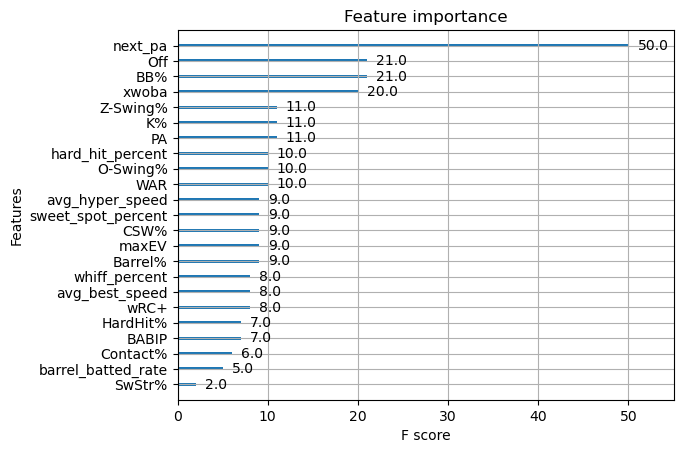

In [24]:
xgb.plot_importance(model)
plt.show()

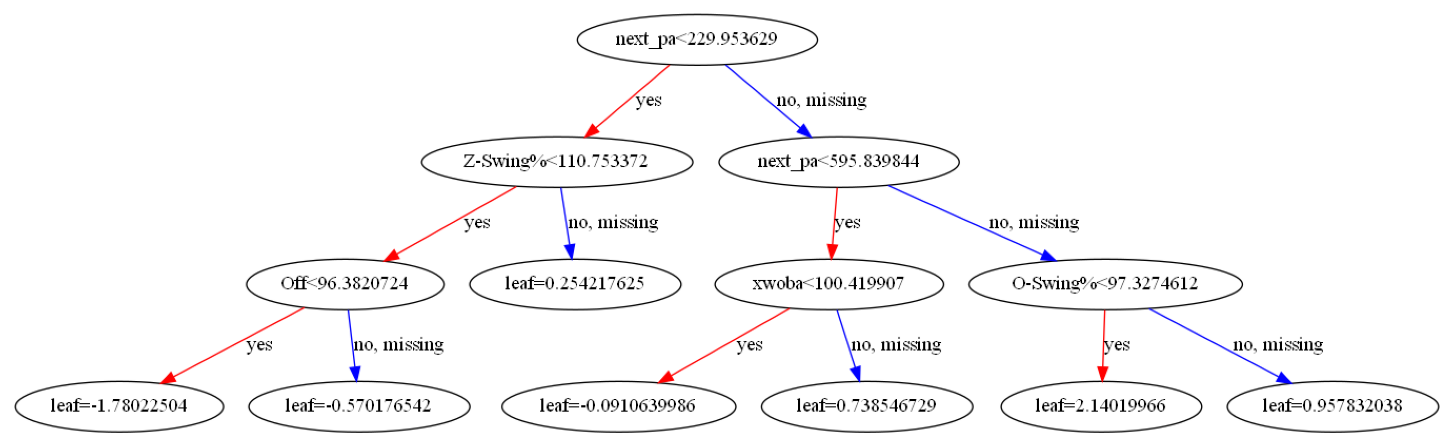

In [25]:
xgb.plot_tree(model)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

#### Metrics

In [26]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

r2 = r2_score(y_true=ytest, y_pred=ypreds)
mae = mean_absolute_error(y_true=ytest, y_pred=ypreds)
rmse = root_mean_squared_error(y_true=ytest, y_pred=ypreds)

print(f"R^2: {r2} \n mse: {mae} \n rmse: {rmse}")

R^2: 0.352294099901145 
 mse: 21.447737589878518 
 rmse: 29.391399172855017


#### 2025 Predections

prepare data, import next_pa

In [27]:
next_pa = pd.read_csv('./predicted_data/pa_25.csv')
next_pa = next_pa.drop(columns=['Unnamed: 0'])

In [28]:
season = z_score_df[z_score_df['Season'] >= 2024].copy()
season = season.reset_index()
season = season.merge(next_pa, on='Name', how='left')
season = season.rename(columns={'avg_pred_pa':'next_pa'})
season = season.drop(columns=['index'])

In [29]:
season_pred = season.drop(columns=['Name', 'woba','player_id', 'pa', 
                                   'bb_percent', 'k_percent', 'woba', 'BsR', 'Def', 
                                   'Season', 'swing_percent', 'Z-Contact%', 'O-Contact%', 'Age'])

In [30]:
preds_2025 = model.predict(season_pred)
preds_2025 = pd.DataFrame(preds_2025)
preds_2025['Name'] = season['Name']
preds_2025

,0,Name
0,69.193085,aaron hicks
1,130.547211,aaron judge
2,71.505859,aaron schunk
3,79.511642,abraham toro
4,80.484703,adael amador
...,...,...
602,81.217728,zach mckinstry
603,103.235786,zach neto
604,68.542793,zach remillard
605,85.041443,zack gelof


In [31]:
preds_2025.to_csv('./predicted_data/wrc_pred/reg_23_preds.csv')